In [20]:
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
from scipy.sparse import csr_matrix, find
import numpy as np
from sklearn.cluster import KMeans
import numpy as np
import random
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.utils import shuffle
from sklearn.metrics import calinski_harabaz_score

In [2]:
file = 'train.dat.txt'
data = open(file, 'r')
# print data

In [3]:
docs = list()
for row in data:
    docs.append(row.rstrip().split(" "))    
# print(docs)

In [4]:
# sperate indices and values
dataIndex = list()
value = list()
for d in docs:
    d_index = list()
    d_value = list()
    for i in range(0,len(d),2):      
        d_index.append(d[i])
    for j in range(1,len(d),2):     
        d_value.append(d[j])
    dataIndex.append(d_index)
    value.append(d_value)
# print len(value)
# print len(dataIndex)

In [5]:
# print len(value[0])
# print len(dataIndex[0])

In [6]:
nrows = len(docs)

idx = {}
tid = 0
nnz = 0
ncol = 0
_max = list()
for d in dataIndex:
    nnz += len(d)
    _max.append(max(d))
    for w in d:
        if w not in idx:
#             print(w)
            idx[w] = tid
            tid += 1

In [7]:

def csr_build(dataIndex, value):
    ind = np.zeros(nnz, dtype=np.int)
    val = np.zeros(nnz, dtype=np.double)
    ptr = np.zeros(nrows+1, dtype=np.int)
    i = 0
    n = 0
    
    for (d,v) in zip(dataIndex, value):
        l = len(d)
        for j in range(l):
#             print j, k
            ind[int(j) + n] = d[j]
            val[int(j) + n] = v[j]
        
        ptr[i+1] = ptr[i] + l
        n += l
        i += 1
    
    mat = csr_matrix((val, ind, ptr), shape=(nrows, max(ind)+1), dtype=np.double)
    mat.sort_indices()
    
    return mat        

In [8]:
mat = csr_build(dataIndex, value)
# print(mat.shape)

In [9]:
# scale matrix and normalize its rows
def csr_idf(mat, copy=False, **kargs):
    r""" Scale a CSR matrix by idf. 
    Returns scaling factors as dict. If copy is True, 
    returns scaled matrix and scaling factors.
    """
    if copy is True:
        mat = mat.copy()
    nrows = mat.shape[0]
    nnz = mat.nnz
    ind, val, ptr = mat.indices, mat.data, mat.indptr
    # document frequency
    df = defaultdict(int)
    for i in ind:
        df[i] += 1
    # inverse document frequency
    for k,v in df.items():
        df[k] = np.log(nrows / float(v))  ## df turns to idf - reusing memory
    # scale by idf
    for i in range(0, nnz):
        val[i] *= df[ind[i]]
        
    return df if copy is False else mat

def csr_l2normalize(mat, copy=False, **kargs):
    r""" Normalize the rows of a CSR matrix by their L-2 norm. 
    If copy is True, returns a copy of the normalized matrix.
    """
    if copy is True:
        mat = mat.copy()
    nrows = mat.shape[0]
    nnz = mat.nnz
    ind, val, ptr = mat.indices, mat.data, mat.indptr
    # normalize
    for i in range(nrows):
        rsum = 0.0    
        for j in range(ptr[i], ptr[i+1]):
            rsum += val[j]**2
        if rsum == 0.0:
            continue  # do not normalize empty rows
        rsum = float(1.0/np.sqrt(rsum))
        for j in range(ptr[i], ptr[i+1]):
            val[j] *= rsum
            
    if copy is True:
        return mat


In [10]:
mat2 = csr_idf(mat, copy=True)
mat3 = csr_l2normalize(mat2, copy=True)

In [11]:
print mat3.shape

(8580, 126356)


In [12]:
# k = 7

In [13]:
def initCentorids(x, k):
    x_shuffle = shuffle(x, random_state=0)
    return x_shuffle[:k,:]

In [14]:
def sim(x1, x2):
    sims = x1.dot(x2.T)
    return sims

In [15]:
def findCentroids(mat, centroids):
    idx = list()
    simsMatrix = sim(mat, centroids)

    for i in range(simsMatrix.shape[0]):
        row = simsMatrix.getrow(i).toarray()[0].ravel()
        top_indices = row.argsort()[-1]
        top_values = row[row.argsort()[-1]]
#         print top_indices
        idx.append(top_indices + 1)
    return idx

In [16]:
# centroids = initCentorids(mat3, k)
# idx = findCentroids(mat3, centroids)
# print idx

In [17]:
def computeMeans(mat, idx, k):
    centroids = list()
    for i in range(1,k+1):
        indi = [j for j, x in enumerate(idx) if x == i]
        members = mat[indi,:]
        if (members.shape[0] > 1):
            centroids.append(members.toarray().mean(0))
    # print centroids
    centroids_csr = csr_matrix(centroids)
    return centroids_csr

In [29]:
def kmeans(k, mat, n_iter):
    centroids = initCentorids(mat, k)
    for _ in range(n_iter): 
        idx = findCentroids(mat, centroids)            
        centroids = computeMeans(mat, idx, k)        
    return idx

In [30]:
x_axis = list()
y_axis = list()
for k in range(3, 22, 2):
    idx = kmeans(k, mat3, 10)
    score = calinski_harabaz_score(mat3.toarray(), idx)
    print k, score
    x_axis.append(k)
    y_axis.append(score)

3 65.5031516578
5 50.7752183402
7 49.863471973
9 44.9782396014
11 40.4213669829
13 37.8967260745
15 35.476224176
17 35.306872261
19 34.3691028615
21 31.002414506


In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

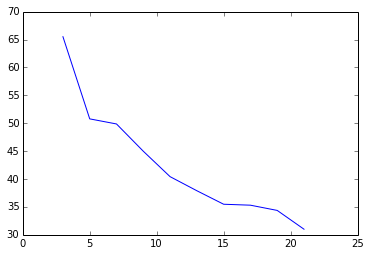

In [39]:
plt.plot(x_axis, y_axis)

In [ ]:
print "Score: "
print(calinski_harabaz_score(mat3.toarray(), idx))

In [224]:
# print result to text file
text_file = open("output.dat.txt", "w")
for i in idx:
    
    text_file.write(str(i) +'\n')
text_file.close()